# 1. Introduction
Name : Muhammad Erico Ricardo

Backround : Mobile phones are widely utilized for a multitude of purposes, including communication, entertainment, professional activities, and increasingly, education. Despite their utility, frequent and unproductive mobile phone use poses a risk of user addiction. This project seeks to develop a classification system for mobile phone users, enabling individuals to identify their usage category and offering targeted interventions to decrease problematic addiction.

In this project i use Mobile Device Usage and User Behavior Dataset from Kaggle :
https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset

dataset provides a comprehensive analysis of mobile device usage patterns and user behavior classification. It contains 700 samples of user data, including metrics such as app usage time, screen-on time, battery drain, and data consumption. Each entry is categorized into one of five user behavior classes, ranging from light to extreme usage, allowing for insightful analysis and modeling.

Key Features:

- User ID: Unique identifier for each user.
- Device Model: Model of the user's smartphone.
- Operating System: The OS of the device (iOS or Android).
- App Usage Time: Daily time spent on mobile applications, measured in minutes.
- Screen On Time: Average hours per day the screen is active.
- Battery Drain: Daily battery consumption in mAh.
- Number of Apps Installed: Total apps available on the device.
- Data Usage: Daily mobile data consumption in megabytes.
- Age: Age of the user.
- Gender: Gender of the user (Male or Female).
- User Behavior Class: Classification of user behavior based on usage patterns (1 to 5).

# 2. Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from xgboost import XGBClassifier
from phik import phik
from imblearn.over_sampling import SMOTENC
from feature_engine.outliers import Winsorizer as winsorizer
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

#package for export and import and model
import pickle
import json

# 3. Data Loading

In [2]:
# Read the dataset
data = pd.read_csv('user_behavior_dataset.csv')
data.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


## 3.1 Quick Overview Data

In [3]:
data['User Behavior Class'].unique()

array([4, 3, 2, 5, 1], dtype=int64)

The data has 11 columns and user behavior class is categorize to 5 behavior

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB


In [5]:
print("Model device : "+ data['Device Model'].unique())
print("--------------------------------------------------")
print("Operating System : " + data['Operating System'].unique())

['Model device : Google Pixel 5' 'Model device : OnePlus 9'
 'Model device : Xiaomi Mi 11' 'Model device : iPhone 12'
 'Model device : Samsung Galaxy S21']
--------------------------------------------------
['Operating System : Android' 'Operating System : iOS']


The data only get data from 5 phone model and 2 Operating System

In [6]:
#check data duplicate
data.duplicated().sum()

0

In [7]:
#check missing value
data.isnull().sum()

User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

# 4. Exploratory Data Analysis (EDA)

In [8]:
# Sorting the data by 'User Behavior Class' from low to high
data.sort_values(by='User Behavior Class', inplace=True)

## 4.1 Looking User Behavior Class Distribution

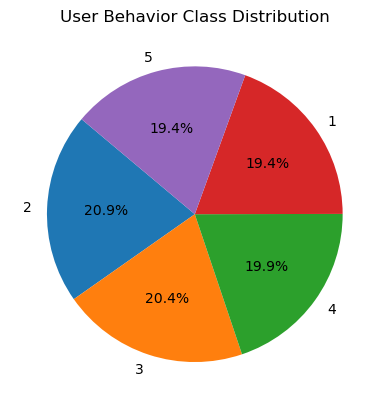

In [9]:
# count the number of unique values in 'User Behavior Class'
user_behavior_class_counts = data['User Behavior Class'].value_counts()

# Creating a pie plot
plt.pie(user_behavior_class_counts, labels=user_behavior_class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('User Behavior Class Distribution')
plt.show()

## 4.2 Looking Gender Distribution

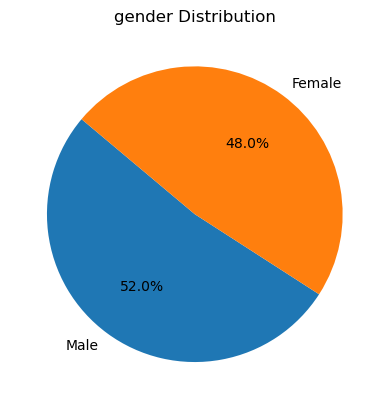

In [10]:
# count the number of unique values in 'gender'
gender_counts = data['Gender'].value_counts()

# Creating a pie plot
plt.pie(gender_counts,labels = gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('gender Distribution')
plt.show()

## 4.3 Generation Distribution

In [11]:
data.loc[data['Age'] < 27, 'Generation'] = 'Gen Z'
data.loc[(data['Age'] >= 27) & (data['Age'] < 42), 'Generation'] = 'Millenial'
data.loc[(data['Age'] >= 42) & (data['Age'] < 60), 'Generation'] = 'Gen X'

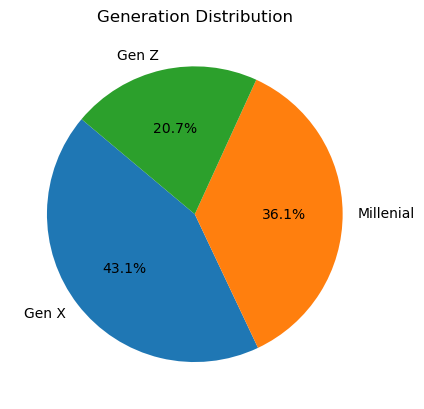

In [12]:
# count the number of unique values in 'Generation'
generation_counts = data['Generation'].value_counts()
# Creating a pie plot
plt.pie(generation_counts, labels=generation_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Generation Distribution')
plt.show()

## 4.4 Operating System Distribution

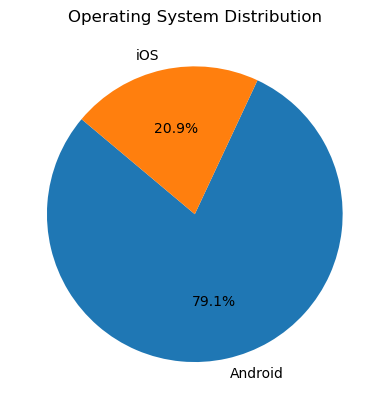

In [13]:
# count the number of unique values in 'Operating System'
os_counts = data['Operating System'].value_counts()
# Creating a pie plot
plt.pie(os_counts, labels=os_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Operating System Distribution')
plt.show()

## 4.5 Total Installed Apps Distribution
First we gonna split every 10 apps installed in the device

In [14]:
data.loc[data['Number of Apps Installed'] <= 10, 'Category Installed Apps'] = '0-10 Apps'
data.loc[(data['Number of Apps Installed'] > 10) & (data['Number of Apps Installed'] <= 20), 'Category Installed Apps'] = '11-20 Apps'
data.loc[(data['Number of Apps Installed'] > 20) & (data['Number of Apps Installed'] <= 30), 'Category Installed Apps'] = '21-30 Apps'
data.loc[(data['Number of Apps Installed'] > 30) & (data['Number of Apps Installed'] <= 40), 'Category Installed Apps'] = '31-40 Apps'
data.loc[(data['Number of Apps Installed'] > 40) & (data['Number of Apps Installed'] <= 50), 'Category Installed Apps'] = '41-50 Apps'
data.loc[(data['Number of Apps Installed'] > 50) & (data['Number of Apps Installed'] <= 60), 'Category Installed Apps'] = '51-60 Apps'
data.loc[(data['Number of Apps Installed'] > 60) & (data['Number of Apps Installed'] <= 70), 'Category Installed Apps'] = '61-70 Apps'
data.loc[(data['Number of Apps Installed'] > 70) & (data['Number of Apps Installed'] <= 80), 'Category Installed Apps'] = '71-80 Apps'
data.loc[(data['Number of Apps Installed'] > 80) & (data['Number of Apps Installed'] <= 90), 'Category Installed Apps'] = '81-90 Apps'
data.loc[(data['Number of Apps Installed'] > 90) & (data['Number of Apps Installed'] <= 100), 'Category Installed Apps'] = '91-100 Apps'

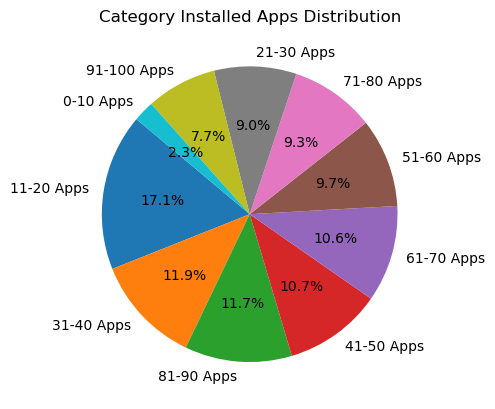

In [15]:
# count the number of unique values in 'Category Installed Apps'
category_installed_apps_counts = data['Category Installed Apps'].value_counts()
# Creating a pie plot
plt.pie(category_installed_apps_counts, labels=category_installed_apps_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Category Installed Apps Distribution')
plt.show()

## 4.6 See Average Data Usage in every behavior class

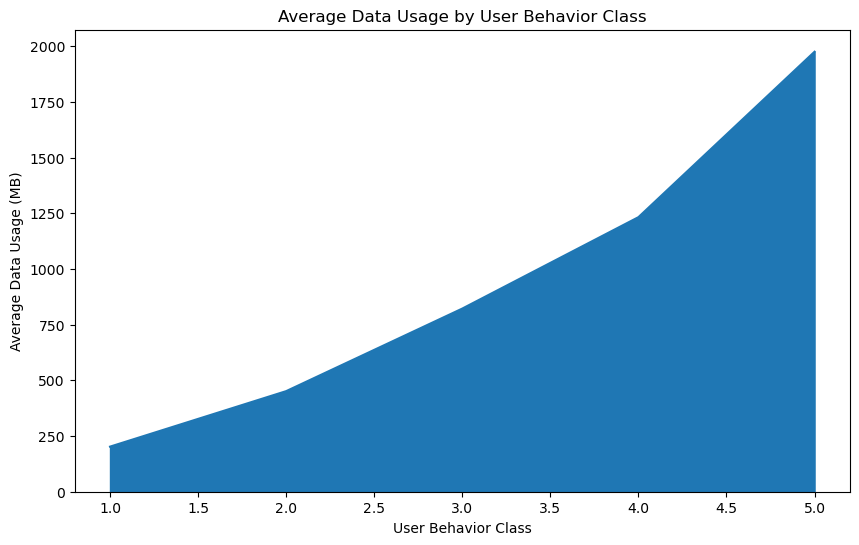

In [16]:
# Creat area plot for average data usage in every behavior class
data.groupby('User Behavior Class')['Data Usage (MB/day)'].mean().plot(kind='area', figsize=(10, 6))
plt.title('Average Data Usage by User Behavior Class')
plt.xlabel('User Behavior Class')
plt.ylabel('Average Data Usage (MB)')
plt.show()



## 4.7 See Average Screen On Time vs Behavior class

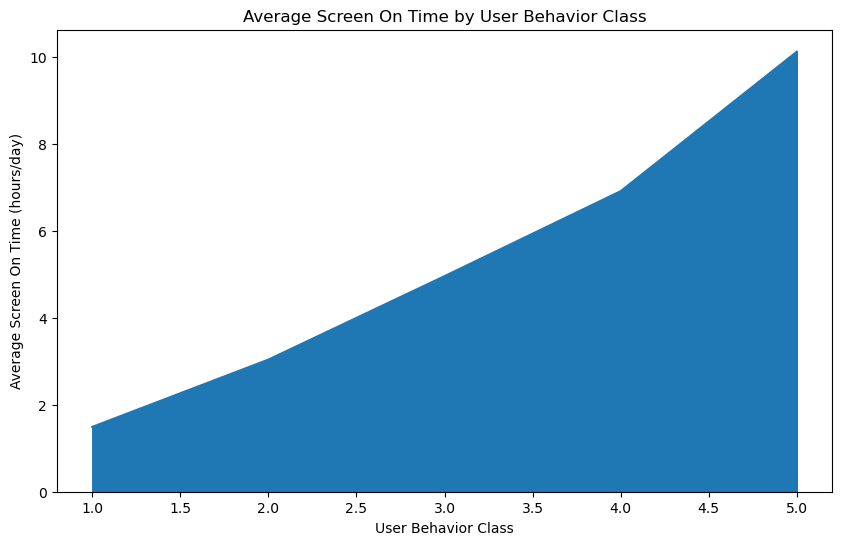

In [17]:
# create area plot for average screen on time in every behavior class
data.groupby('User Behavior Class')['Screen On Time (hours/day)'].mean().plot(kind='area', figsize=(10, 6))
plt.title('Average Screen On Time by User Behavior Class')
plt.xlabel('User Behavior Class')
plt.ylabel('Average Screen On Time (hours/day)')
plt.show()


## 4.8 See average battery Drain vs Behavior Class

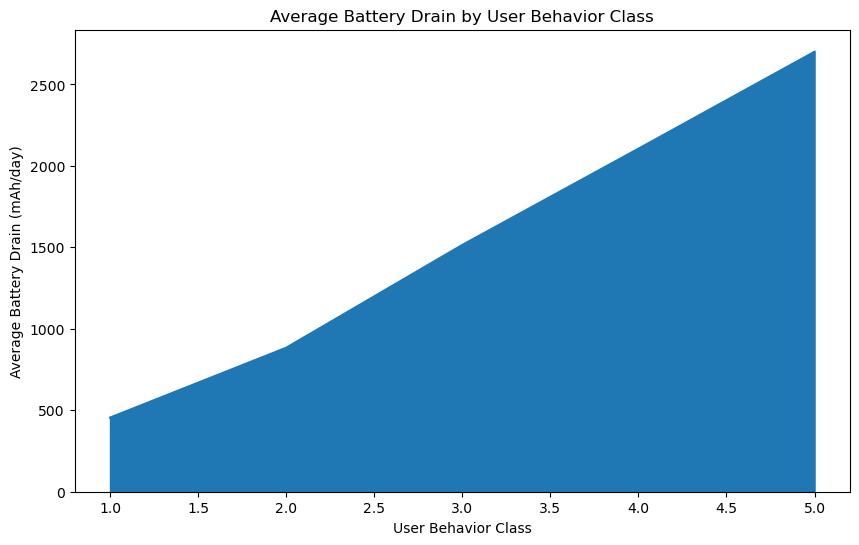

In [18]:
# creat area plot for average screen on time in every behavior class
data.groupby('User Behavior Class')['Battery Drain (mAh/day)'].mean().plot(kind='area', figsize=(10, 6))
plt.title('Average Battery Drain by User Behavior Class')
plt.xlabel('User Behavior Class')
plt.ylabel('Average Battery Drain (mAh/day)')
plt.show()

## 4.9 See correlation between Screen On Time and Data Usage to Behavior Class


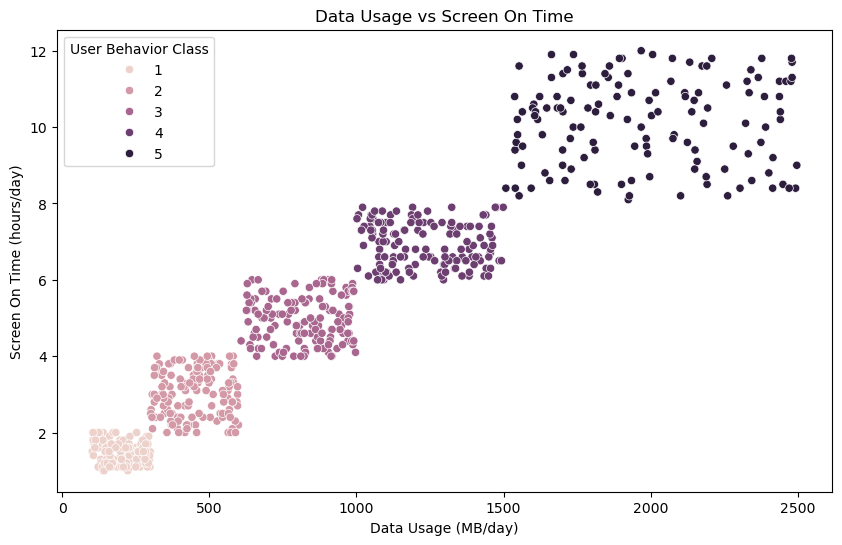

In [19]:
# See Correlation between 'Data Usage (MB/day)' and 'Screen On Time (hours/day)'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Data Usage (MB/day)', y='Screen On Time (hours/day)', data=data, hue='User Behavior Class')
plt.title('Data Usage vs Screen On Time')
plt.xlabel('Data Usage (MB/day)')
plt.ylabel('Screen On Time (hours/day)')
plt.legend(title='User Behavior Class')
plt.show()

## 4.10 Summary of Exploratory Data Analysis

The user behavior class distribution is **well-balanced**, with each class representing approximately **20%** of the total users.

Demographically, **Generation X** users are more prevalent in the data than Millennials and Generation Z.

Regarding operating systems, **80%** of users operate on **Android**, while **20%** use **iOS**.

Across all behavior classes, there's a consistent increase in **average data usage, average screen-on time, and average battery drain**. This trend indicates that **Class 1 users interact minimally** with their mobile phones, whereas **Class 5 users exhibit the highest levels of interaction**.

# 5. Feature Engineering

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 235 to 232
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
 11  Generation                  700 non-null    object 
 12  Category Installed Apps     700 non-null    object 
dtypes: float64(1), int64(7), object(5)
mem

Data used in this model only data numerical and categorical that :
List data Numerical :
1. App Usage Time (Continue)
2. Screen On Time (Continue)
3. Battery Drain (Continue)
4. Number of Apps Installed (Continue)
5. Data Usage (Continue)
6. Age (Dicrete)
7. User Behavior Class (Dicrete)

List data Categorical :
1. Device Model (Nominal) 
2. Operating System (Nominal)
3. Gender (Nominal)
4. Generation (Nominal)
5. Category Installed Apps (Nominal)

In [21]:
data_numerical = ['Data Usage (MB/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Age', 'Number of Apps Installed', 'App Usage Time (min/day)', 'User Behavior Class']
data_categorical = ['Device Model', 'Operating System','Gender']

In [22]:
x = data[data_numerical + data_categorical].drop(columns=['User Behavior Class'])
y = data['User Behavior Class']

In [23]:
x

,Data Usage (MB/day),Screen On Time (hours/day),Battery Drain (mAh/day),Age,Number of Apps Installed,App Usage Time (min/day),Device Model,Operating System,Gender
235,295,1.4,369,19,18,37,Xiaomi Mi 11,Android,Female
323,156,1.3,490,31,14,76,Xiaomi Mi 11,Android,Female
163,139,2.0,469,22,18,32,iPhone 12,iOS,Male
399,203,1.5,571,29,10,49,OnePlus 9,Android,Male
398,221,1.6,323,43,18,41,OnePlus 9,Android,Female
...,...,...,...,...,...,...,...,...,...
211,2017,10.9,2752,18,86,481,Samsung Galaxy S21,Android,Male
511,1682,10.8,2911,39,89,567,Samsung Galaxy S21,Android,Male
208,1990,9.3,2606,41,92,539,OnePlus 9,Android,Male
394,1774,9.2,2663,45,84,589,Google Pixel 5,Android,Female


In [24]:
y

235    1
323    1
163    1
399    1
398    1
      ..
211    5
511    5
208    5
394    5
232    5
Name: User Behavior Class, Length: 700, dtype: int64

## 5.1 Split data train and data test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (560, 9)
X_test shape:  (140, 9)


In [26]:
#Check the shape of the data y
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)
y_train.info()

y_train shape:  (560,)
y_test shape:  (140,)
<class 'pandas.core.series.Series'>
Index: 560 entries, 71 to 144
Series name: User Behavior Class
Non-Null Count  Dtype
--------------  -----
560 non-null    int64
dtypes: int64(1)
memory usage: 8.8 KB


## 5.2 Handling Missing Value
Because in data overview we know that no missing value, soo we can skip this one.

## 5.3 Feature Selection
See X_train data type

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560 entries, 71 to 144
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Data Usage (MB/day)         560 non-null    int64  
 1   Screen On Time (hours/day)  560 non-null    float64
 2   Battery Drain (mAh/day)     560 non-null    int64  
 3   Age                         560 non-null    int64  
 4   Number of Apps Installed    560 non-null    int64  
 5   App Usage Time (min/day)    560 non-null    int64  
 6   Device Model                560 non-null    object 
 7   Operating System            560 non-null    object 
 8   Gender                      560 non-null    object 
dtypes: float64(1), int64(5), object(3)
memory usage: 43.8+ KB


Using Phik to see correlation from each data

In [28]:
phik_overview = pd.concat([X_train, y_train], axis=1).phik_matrix()
phik_overview

interval columns not set, guessing: ['Data Usage (MB/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Age', 'Number of Apps Installed', 'App Usage Time (min/day)', 'User Behavior Class']


,Data Usage (MB/day),Screen On Time (hours/day),Battery Drain (mAh/day),Age,Number of Apps Installed,App Usage Time (min/day),Device Model,Operating System,Gender,User Behavior Class
Data Usage (MB/day),1.000000,0.927484,0.928583,0.173461,0.928492,0.937551,0.000000,0.118598,0.218338,0.997134
Screen On Time (hours/day),0.927484,1.000000,0.919686,0.000000,0.924592,0.930832,0.000000,0.000000,0.000000,0.995067
Battery Drain (mAh/day),0.928583,0.919686,1.000000,0.049479,0.926576,0.932343,0.000000,0.000000,0.139787,0.995257
Age,0.173461,0.000000,0.049479,1.000000,0.160216,0.225809,0.000000,0.065251,0.120363,0.162679
Number of Apps Installed,0.928492,0.924592,0.926576,0.160216,1.000000,0.934028,0.000000,0.000000,0.055233,0.996129
App Usage Time (min/day),0.937551,0.930832,0.932343,0.225809,0.934028,1.000000,0.045643,0.171158,0.000000,0.998399
Device Model,0.000000,0.000000,0.000000,0.000000,0.000000,0.045643,1.000000,1.000000,0.000000,0.000000
Operating System,0.118598,0.000000,0.000000,0.065251,0.000000,0.171158,1.000000,1.000000,0.000000,0.018403
Gender,0.218338,0.000000,0.139787,0.120363,0.055233,0.000000,0.000000,0.000000,1.000000,0.062202
User Behavior Class,0.997134,0.995067,0.995257,0.162679,0.996129,0.998399,0.000000,0.018403,0.062202,1.000000


Based from corelation, wee can see that there is high correlation between few column to User Behavior Class, and i choose to pick only using above 90% correlation in this model. so im gonna use :
1. Data Usage (MB/day)
2. Screen On Time (hours/day)
3. Battery Drain (mAh/day)
4. Number of Apps Installed
5. App Usage Time (min/day)



In [29]:
features = ['Data Usage (MB/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'App Usage Time (min/day)']
X_train = X_train[features]

## 5.4 Check Cardinality

In [30]:
X_train.nunique()

Data Usage (MB/day)           488
Screen On Time (hours/day)    107
Battery Drain (mAh/day)       515
Number of Apps Installed       86
App Usage Time (min/day)      349
dtype: int64

Because from cardinality categorize still small, soo im not gonna change anything

## 5.5 Handling Outlier

In [31]:
Numeric_continuous = ['Data Usage (MB/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'App Usage Time (min/day)']
Numeric_discrete = ['Age','user Bhavior Class']

In [32]:
data_extreme = []
data_skew = []
data_normal = []

def cek_skew(data):
    for column in Numeric_continuous:
        if data[column].skew() >= 1 or data[column].skew() <= -1:
            data_extreme.append(column)
        elif data[column].skew() >= 0.5 or data[column].skew() <= -0.5:
            data_skew.append(column)
        else:
            data_normal.append(column)
    print('Data extreme = ', data_extreme)
    print('Data skew = ', data_skew)
    print('Data normal = ', data_normal)

cek_skew(X_train)

Data extreme =  []
Data skew =  ['Data Usage (MB/day)']
Data normal =  ['Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 'Number of Apps Installed', 'App Usage Time (min/day)']


For data skew , we gonna use Winsorizer with iqr fold 1.5 and for data normal we gonna use gaussian only.

In [33]:
normal_cap = winsorizer(capping_method='gaussian',
                        fold = 3,
                        tail = 'both',
                        variables = data_normal)
Skew_cap = winsorizer(capping_method='iqr',
                         fold=1.5,
                         tail = 'both',
                         variables = data_skew)

## 5.6 Data Scling

In [34]:
num_normal_scale = Pipeline([
    ('winsorizer', normal_cap),
    ('scaler', StandardScaler())
])

num_skew_scale = Pipeline([ 
    ('winsorizer', Skew_cap),
    ('robust', RobustScaler())
])

## 5.7 Data Encoding

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_skew', num_skew_scale,data_extreme),
        ('num_normal',num_normal_scale, data_normal)
        
    ], remainder='drop')

## 5.8 Data Balancing
The data overview shows that each User Behavior Class has an approximately 20% representation, so data balancing isn't necessary.



In [36]:
# See count every data category in data['User Behavior Class']
data['User Behavior Class'].value_counts()

User Behavior Class
2    146
3    143
4    139
1    136
5    136
Name: count, dtype: int64

# 6. Model 

Im gonna Search for the best model using cross validation to compare few model like :
1. SVC model
2. DecisionTreeClassifier model
3. RandomForestClassifier model
4. KNeighborsClassifier model
5. GaussianNB model
6. XGBClassifier model

In [37]:
# Create a pipeline for each model to be compared
pipe_svc = Pipeline([('preprocessor', preprocessor), ('classifier', SVC())])
pipe_dt = Pipeline([('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(random_state=10))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=10))])
pipe_knn = Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])
pipe_nb = Pipeline([('preprocessor', preprocessor),('classifier', GaussianNB())])
pipe_xgb = Pipeline([('preprocessor', preprocessor),('classifier', XGBClassifier())])

In [38]:
# Create a StratifiedKFold object for cross-validation
skfold = StratifiedKFold(n_splits = 5)

In [39]:
# Check unique classes in y_train
print("Unique classes in y_train:", np.unique(y_train))
# Adjust y_train if necessary
if np.min(y_train) == 1:  # Assuming classes start from 1
    y_train = y_train - 1  # Shift classes to start from 0
# Perform cross-validation for each model
cv_svm_model = cross_val_score(pipe_svc, X_train, y_train, cv=skfold, scoring='accuracy', n_jobs=-1)
cv_dt_model = cross_val_score(pipe_dt, X_train, y_train, cv=skfold, scoring='accuracy', n_jobs=-1)
cv_rf_model = cross_val_score(pipe_rf, X_train, y_train, cv=skfold, scoring='accuracy', n_jobs=-1)
cv_knn_model = cross_val_score(pipe_knn, X_train, y_train, cv=skfold, scoring='accuracy', n_jobs=-1)
cv_nb_model = cross_val_score(pipe_nb, X_train, y_train, cv=skfold, scoring='accuracy', n_jobs=-1)
cv_xgb_model = cross_val_score(pipe_xgb, X_train, y_train, cv=skfold, scoring='accuracy', n_jobs=-1)

Unique classes in y_train: [1 2 3 4 5]


In [40]:
# Print the cross-validation scores for each model
name_model = []
cv_scores = 0
for cv,name in zip([cv_svm_model,cv_dt_model,cv_rf_model,cv_knn_model,cv_nb_model,cv_xgb_model],
                   ['svm_model','dt_model','rf_model','knn_model','nb_model','xgb_model']):
  print(name)
  print('f1score - All - Cross Validation :', cv)
  print('f1score - Mean - Cross Validation :', cv.mean())
  print('f1score - std - Cross Validation :', cv.std())
  print('f1score - Range of Test Set :', (cv.mean()-cv.std()), '-' , (cv.mean()+cv.std()))
  print('-'*50)
  if cv.mean() > cv_scores:
    cv_scores = cv.mean()
    name_model = name
  else:
    pass
print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', cv_scores)

svm_model
f1score - All - Cross Validation : [1. 1. 1. 1. 1.]
f1score - Mean - Cross Validation : 1.0
f1score - std - Cross Validation : 0.0
f1score - Range of Test Set : 1.0 - 1.0
--------------------------------------------------
dt_model
f1score - All - Cross Validation : [0.99107143 1.         1.         0.97321429 1.        ]
f1score - Mean - Cross Validation : 0.9928571428571429
f1score - std - Cross Validation : 0.010412414097938041
f1score - Range of Test Set : 0.9824447287592049 - 1.003269556955081
--------------------------------------------------
rf_model
f1score - All - Cross Validation : [1. 1. 1. 1. 1.]
f1score - Mean - Cross Validation : 1.0
f1score - std - Cross Validation : 0.0
f1score - Range of Test Set : 1.0 - 1.0
--------------------------------------------------
knn_model
f1score - All - Cross Validation : [1. 1. 1. 1. 1.]
f1score - Mean - Cross Validation : 1.0
f1score - std - Cross Validation : 0.0
f1score - Range of Test Set : 1.0 - 1.0
------------------------

Based from cross validation, the best model is SVM with f1score 100% then decision tree and KNN. in next code im gonna use SVM.

## 6.2 Model Definition
Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. Here's a simple explanation of how it works:

### Basic Concept

1. **Objective**: The main goal of SVM is to find the best boundary (or hyperplane) that separates different classes in the data. This boundary should maximize the margin between the classes.

2. **Hyperplane**: In a two-dimensional space, a hyperplane is simply a line that divides the space into two parts. In higher dimensions, it becomes a plane or a hyperplane.

3. **Support Vectors**: The data points that are closest to the hyperplane are called support vectors. These points are critical because they are the ones that influence the position and orientation of the hyperplane. The SVM algorithm focuses on these points to define the optimal boundary.

### How SVM Works

1. **Training Phase**:
   - The algorithm takes a set of labeled training data (features and corresponding class labels).
   - It tries to find the hyperplane that best separates the classes while maximizing the margin between them.

2. **Margin**: The margin is the distance between the hyperplane and the nearest data points from either class. A larger margin is preferred because it indicates a better generalization to unseen data.

3. **Kernel Trick**: SVM can handle non-linear data by using a technique called the "kernel trick." This involves transforming the data into a higher-dimensional space where a linear hyperplane can be used to separate the classes. Common kernels include:
   - **Linear Kernel**: For linearly separable data.
   - **Polynomial Kernel**: For polynomial decision boundaries.
   - **Radial Basis Function (RBF) Kernel**: For more complex boundaries.

### Prediction Phase

Once the SVM model is trained, it can classify new data points by determining which side of the hyperplane they fall on. If a new point is on one side, it belongs to one class; if it's on the other side, it belongs to the other class.

### Summary

- **SVM** is a powerful algorithm for classification tasks that works by finding the optimal hyperplane to separate different classes.
- It focuses on support vectors, which are the critical data points that define the boundary.
- It can handle both linear and non-linear data using different kernels.

Overall, SVM is known for its effectiveness in high-dimensional spaces and is widely used in various applications, including image recognition, text classification, and bioinformatics.

## 6.3 Model Training

In [41]:
model = SVC()

In [42]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [43]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_skew',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5,
                                                                              tail='both',
                                                                              variables=['Data '
                                                                                         'Usage '
                                                                                         '(MB/day)'])),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  []),
                                                 ('num_normal',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(fold=3,
                                                                              tail='both',
                                                                              variables=['Screen '
                                                                                         'On '
                                                                                         'Time '
                                                                                         '(hours/day)',
                                                                                         'Battery '
                                                                                         'Drain '
                                                                                         '(mAh/day)',
                                                                                         'Number '
                                                                                         'of '
                                                                                         'Apps '
                                                                                         'Installed',
                                                                                         'App '
                                                                                         'Usage '
                                                                                         'Time '
                                                                                         '(min/day)'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Screen On Time (hours/day)',
                                                   'Battery Drain (mAh/day)',
                                                   'Number of Apps Installed',
                                                   'App Usage Time '
                                                   '(min/day)'])])),
                ('classifier', SVC())])

# 9. Model Evaluation

## 9.1 Model Evaluation
do prediction for X_train and X_test

In [44]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [45]:
print("Classification Report for Training Set:")
print(classification_report(y_train, y_pred_train))

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       117
           2       1.00      1.00      1.00       114
           3       1.00      1.00      1.00       111
           4       1.00      1.00      1.00       109

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [46]:
# Adjust y_test
if np.min(y_test) == 1:  # Assuming classes start from 1
    y_test = y_test - 1  # Shift classes to start from 0

In [47]:
print("Classification Report for Testing Set:")
print(classification_report(y_test, y_pred_test))

Classification Report for Testing Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        27

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



Based from acuration we got 100% accutation.

# 10. Model Saving

In [48]:
# Save model
with open('model.pkl', 'wb') as file:
    pickle.dump(clf, file)

with open('data_model.txt', 'w') as file:
    json.dump(features, file)